In [10]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----------------- ---------------------- 5.8/13.3 MB 32.0 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 38.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/932.3 kB ? eta -:--:--
   --------------------------------------- 932.3/932.3 kB 44.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt

In [3]:
# Cargar datos
df = pd.read_csv(
    r'C:\Users\USUARIO\OneDrive - yachaytech.edu.ec\YachayTech\Time_series\cleaned_train.csv',
    parse_dates=['date'],
    low_memory=False
)
# Preparar dataframe para Prophet
prophet_df = df[['date', 'sales', 'onpromotion', 'oil_price', 'holiday_status']].copy()

# Renombrar columnas según Prophet
prophet_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Convertir 'holiday_status' a binario (0 = normal, 1 = holiday)
prophet_df['holiday_status'] = prophet_df['holiday_status'].apply(lambda x: 1 if x == 'Holiday' else 0)

# Mostrar muestra
print(prophet_df.head())


          ds    y  onpromotion  oil_price  holiday_status
0 2013-01-01  0.0            0  93.139999               1
1 2013-01-01  0.0            0  93.139999               1
2 2013-01-01  0.0            0  93.139999               1
3 2013-01-01  0.0            0  93.139999               1
4 2013-01-01  0.0            0  93.139999               1


In [4]:
# Define cutoff date
cutoff_date = '2017-01-01'

# Train set (before 2017)
prophet_train = prophet_df[prophet_df['ds'] < cutoff_date]

# Validation set (2017)
prophet_val = prophet_df[prophet_df['ds'] >= cutoff_date]

In [5]:
# Create and configure the Prophet model
model = Prophet()
model.add_regressor('onpromotion')
model.add_regressor('oil_price')
model.add_regressor('holiday_status')

In [6]:
# Train only on the training set
model.fit(prophet_train)

17:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:04:49 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Forecast using validation regressors
forecast_val = model.predict(prophet_val[['ds', 'onpromotion', 'oil_price', 'holiday_status']])


In [10]:
# Compare predicted and actual values
y_pred = forecast_val['yhat'].values
y_true = prophet_val['y'].values

In [14]:
# Ensure no negative values
y_true_clipped = np.maximum(y_true, 0)
y_pred_clipped = np.maximum(y_pred, 0)

The following evaluation metrics will be used to evaluate the performance of the models.

- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Squared Logarithmic Error (MSLE)
- Root Mean Squared Logarithmic Error (RMSLE)

The primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE).

In [15]:
# MAE
mae = mean_absolute_error(y_true, y_pred)

# MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MSLE
msle = mean_squared_log_error(y_true_clipped, y_pred_clipped)

# RMSLE
rmsle = np.sqrt(msle)

# Print all results
print(f"MAE:   {mae:.2f}")
print(f"MSE:   {mse:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MSLE:  {msle:.4f}")
print(f"RMSLE: {rmsle:.4f}")


MAE:   383.09
MSE:   1264232.68
RMSE:  1124.38
MSLE:  5.8143
RMSLE: 2.4113


 RMSE >> MAE, so the dataset likely contains large spikes or outliers that the model struggles to predict.

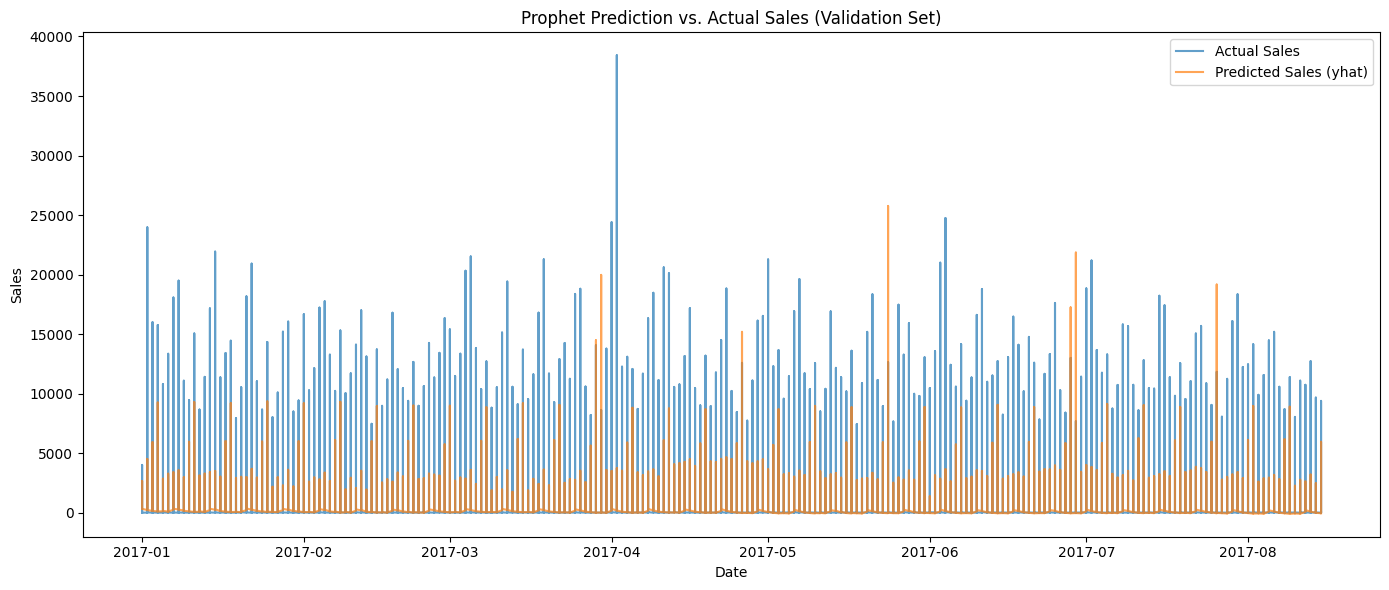

In [12]:
# Plot the prediction vs actual sales
plt.figure(figsize=(14, 6))
plt.plot(prophet_val['ds'], y_true, label='Actual Sales', alpha=0.7)
plt.plot(prophet_val['ds'], y_pred, label='Predicted Sales (yhat)', alpha=0.7)
plt.title("Prophet Prediction vs. Actual Sales (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

There may be outliers or large spikes in sales that Prophet isn’t capturing well.
Prophet is designed for smoother patterns.

Group by store or family and model separately (e.g., Prophet per store-family).

In [20]:
# Load data
data_fam = pd.read_csv(
    r'C:\Users\USUARIO\OneDrive - yachaytech.edu.ec\YachayTech\Time_series\cleaned_train.csv',
    parse_dates=['date'],
    low_memory=False
)

# Keep the 'family' column — critical for per-family modeling
prophet_fam = data_fam[['date', 'family', 'sales', 'onpromotion', 'oil_price', 'holiday_status']].copy()

# Rename columns for Prophet
prophet_fam.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# Convert holiday_status to binary
prophet_fam['holiday_status'] = prophet_fam['holiday_status'].apply(lambda x: 1 if x == 'Holiday' else 0)

# Preview
print(prophet_fam.head())




          ds      family    y  onpromotion  oil_price  holiday_status
0 2013-01-01  AUTOMOTIVE  0.0            0  93.139999               1
1 2013-01-01   BABY CARE  0.0            0  93.139999               1
2 2013-01-01      BEAUTY  0.0            0  93.139999               1
3 2013-01-01   BEVERAGES  0.0            0  93.139999               1
4 2013-01-01       BOOKS  0.0            0  93.139999               1


In [18]:
def train_and_evaluate_family(df, family_name):
    df_family = df[df['family'] == family_name].copy()

    # Skip if not enough data
    if len(df_family) < 100:
        print(f"Skipping {family_name}: not enough data.")
        return None

    # Split into train and validation
    cutoff_date = '2017-01-01'
    train_df = df_family[df_family['ds'] < cutoff_date]
    val_df = df_family[df_family['ds'] >= cutoff_date]

    if len(val_df) < 1:
        print(f"Skipping {family_name}: no validation data.")
        return None

    # Train Prophet
    model = Prophet()
    model.add_regressor('onpromotion')
    model.add_regressor('oil_price')
    model.add_regressor('holiday_status')
    model.fit(train_df)

    # Predict
    future = val_df[['ds', 'onpromotion', 'oil_price', 'holiday_status']]
    forecast = model.predict(future)

    # Evaluate
    y_true = val_df['y'].values
    y_pred = forecast['yhat'].values

    # Clip negatives for log errors
    y_true_c = np.maximum(y_true, 0)
    y_pred_c = np.maximum(y_pred, 0)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(y_true_c, y_pred_c)
    rmsle = np.sqrt(msle)

    return {
        'family': family_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MSLE': msle,
        'RMSLE': rmsle
    }


In [21]:
results = []

for fam in prophet_fam['family'].unique():
    metrics = train_and_evaluate_family(prophet_fam, fam)
    if metrics:
        results.append(metrics)

18:53:06 - cmdstanpy - INFO - Chain [1] start processing
18:53:21 - cmdstanpy - INFO - Chain [1] done processing
18:53:26 - cmdstanpy - INFO - Chain [1] start processing
18:53:40 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:54:08 - cmdstanpy - INFO - Chain [1] done processing
18:54:13 - cmdstanpy - INFO - Chain [1] start processing
18:54:45 - cmdstanpy - INFO - Chain [1] done processing
18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:27 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:46 - cmdstanpy - INFO - Chain [1] done processing
18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:11 - cmdstanpy - INFO - Chain [1]

In [22]:
results_df = pd.DataFrame(results)
results_df.sort_values(by='RMSLE', inplace=True)

print(results_df)

                        family          MAE           MSE         RMSE  \
1                    BABY CARE     0.450790  4.941252e-01     0.702940   
4                        BOOKS     0.498758  4.376408e-01     0.661544   
17             HOME APPLIANCES     0.770387  1.076249e+00     1.037424   
14                    HARDWARE     1.252352  3.331457e+00     1.825228   
0                   AUTOMOTIVE     4.001740  2.995138e+01     5.472786   
15          HOME AND KITCHEN I    19.794232  1.088327e+03    32.989802   
2                       BEAUTY     3.947500  3.458449e+01     5.880858   
25               PERSONAL CARE   151.612601  5.561477e+04   235.827844   
9                         DELI   152.786930  4.410641e+04   210.015268   
21                    LINGERIE     4.763126  5.215620e+01     7.221925   
18                   HOME CARE   171.825850  4.516449e+04   212.519395   
7                     CLEANING   522.728449  6.360389e+05   797.520444   
26                PET SUPPLIES     6.5

19:31:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing


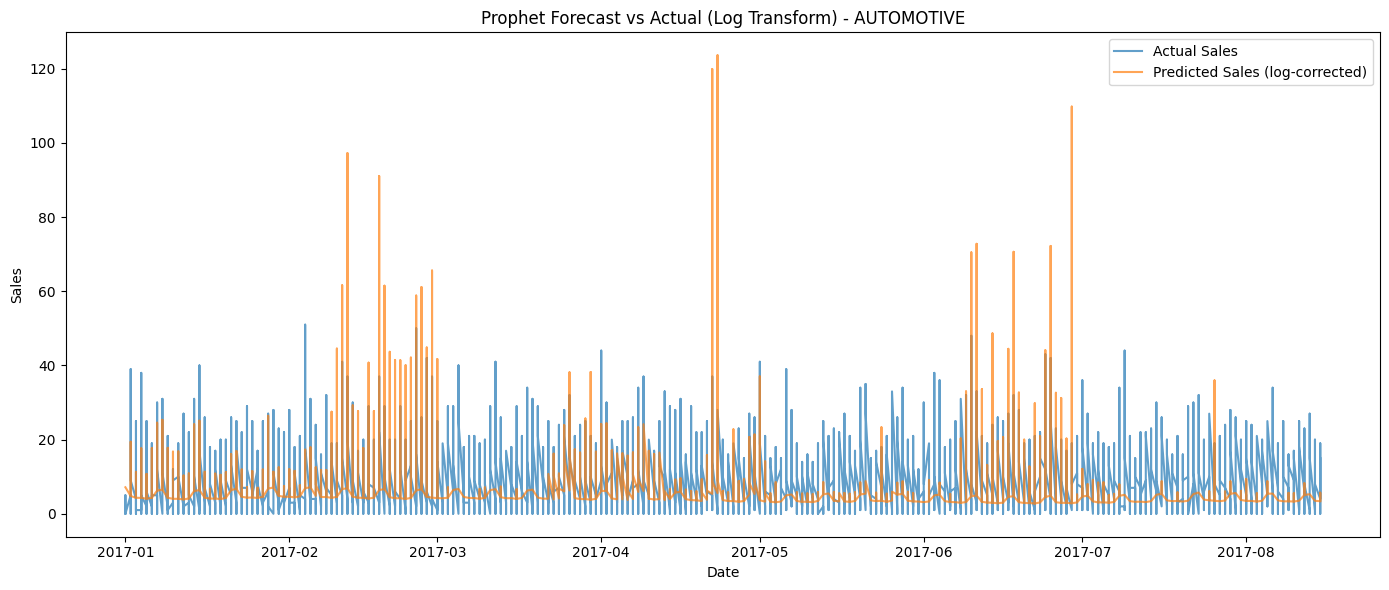

In [24]:
import matplotlib.pyplot as plt

# Choose the family
target_family = 'AUTOMOTIVE'

# Filter the data
df_family = prophet_fam[prophet_fam['family'] == target_family].copy()

# Apply log1p to avoid issues with log(0)
df_family['y'] = np.log1p(df_family['y'])

# Split
cutoff_date = '2017-01-01'
train_df = df_family[df_family['ds'] < cutoff_date]
val_df = df_family[df_family['ds'] >= cutoff_date]

# Train Prophet
model = Prophet()
model.add_regressor('onpromotion')
model.add_regressor('oil_price')
model.add_regressor('holiday_status')
model.fit(train_df)

# Predict on validation set
future = val_df[['ds', 'onpromotion', 'oil_price', 'holiday_status']]
forecast = model.predict(future)

# Invert log1p → back to original sales scale
y_pred = np.expm1(forecast['yhat'].values)
y_true = np.expm1(val_df['y'].values)  # Also undo the true y

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(val_df['ds'], y_true, label='Actual Sales', alpha=0.7)
plt.plot(val_df['ds'], y_pred, label='Predicted Sales (log-corrected)', alpha=0.7)
plt.title(f"Prophet Forecast vs Actual (Log Transform) - {target_family}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()
